### Feature Impacts on Noisy Data
We will generate data points randomly for both training and test sets, and see if our feature tracking methods can help in a model's training phase when data is extremely noisy.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
from helper_plots import plot_feature_importances_per_iter, plot_feature_impacts_per_iter, plot_prediction_feature_impacts

C:\Users\cf660\AppData\Local\Temp\ipykernel_16080\1708416278.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\cf660\Desktop\fyp\code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X, y = shap.datasets.nhanesi()
df = pd.DataFrame(X)
df['survival_times'] = y
df = df.dropna(axis=1)
df.isna().sum().sum()
df

,sex_isFemale,age,physical_activity,alkaline_phosphatase_isUnacceptable,alkaline_phosphatase_isTestnotdone,SGOT_isUnacceptable,SGOT_isTestnotdone,BUN_isUnacceptable,BUN_isTestnotdone,calcium_isUnacceptable,...,urine_hematest_isSmall,urine_hematest_isModerate,urine_hematest_isLarge,urine_hematest_isBlankbutapplicable,sedimentation_rate_isBlankbutapplicable,uric_acid_isUnacceptable,uric_acid_isTestnotdone,systolic_blood_pressure,bmi,survival_times
20751,False,51,3,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,110.0,25.406803,-16.916667
20753,False,41,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,136.0,24.588331,-17.166667
20754,True,31,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,110.0,23.756502,-17.666667
20755,False,48,2,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,126.0,28.610011,-17.250000
20756,True,29,3,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,98.0,19.216489,-17.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25043,True,63,2,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,150.0,35.425033,-17.000000
25046,True,56,2,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,98.0,22.069132,-17.083333
25049,True,47,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,108.0,17.915199,-17.083333
25057,True,61,8,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,180.0,27.331622,-17.083333


In [3]:
np.random.seed(42)
X = df.drop('survival_times', axis=1)
y = df['survival_times']
feature_name_mappings = {i: f'{X.columns[i]}' for i in range(len(X.columns))}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [4]:
from feature_tracker import CustomGBR
# Train CustomGBR with early stopping
gbr = CustomGBR(n_estimators=500, learning_rate=0.1, max_depth=3, validation_fraction=0.2, n_iter_no_change=10, tol=0.01, random_state=42)
gbr.fit(X_train, y_train)
print(f'gbr fit with {gbr.n_estimators_} estimators from early stopping')

gbr fit with 52 estimators from early stopping


#### Comparing feature tracking vs traditional early stopping methods

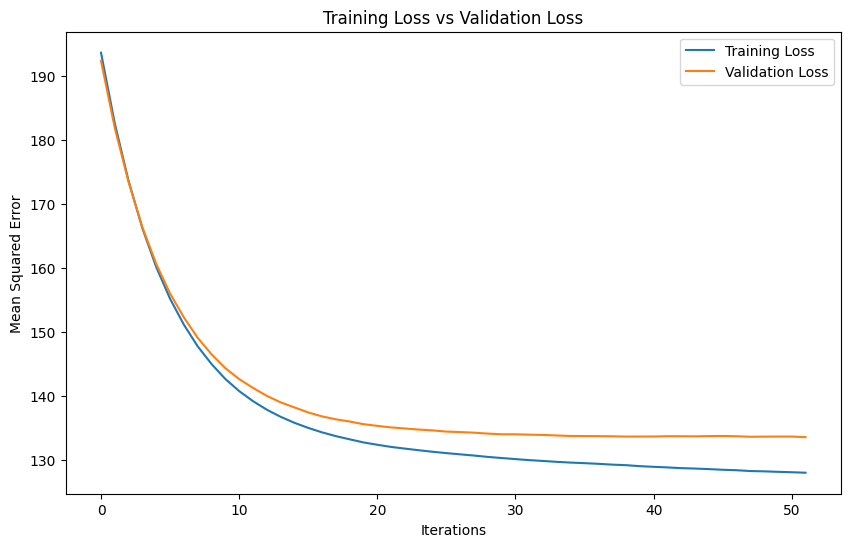

In [5]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

mse_train = [mean_squared_error(y_train, y_pred) for y_pred in gbr.staged_predict(X_train)]
mse_test = [mean_squared_error(y_test, y_pred) for y_pred in gbr.staged_predict(X_test)]

# Plotting the training loss vs. validation loss
plt.figure(figsize=(10, 6))
plt.plot(mse_train, label='Training Loss')
plt.plot(mse_test, label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

#### Normal Feature Importances

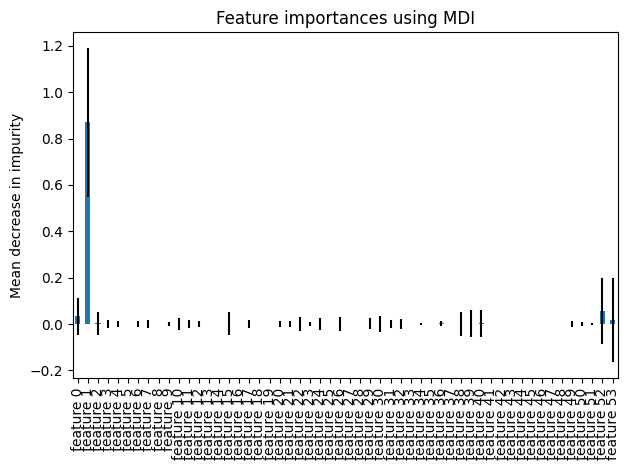

In [6]:
importances = gbr.feature_importances_
std = np.std([tree[0].feature_importances_ for tree in gbr.estimators_], axis=0)
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Tracking Feature Importances and Impacts; with early stopping

#### Feature Importance Tracking

In [7]:
def get_feature_importance_early_stopping_iter(feature_importances_df, feature_idx, threshold=0.1, n_iter_no_change=10):
    df_feature_per_iter = pd.DataFrame(feature_importances_df[feature_idx])
    df_feature_per_iter['rolling_max_importance'] = df_feature_per_iter[feature_idx].rolling(n_iter_no_change).max()
    df_below_thresh = df_feature_per_iter[df_feature_per_iter['rolling_max_importance'] < threshold]
    if len(df_below_thresh) < 1:
        return len(df_feature_per_iter)
    return min(df_below_thresh.index)


def get_feature_impact_early_stopping_iter(feature_impacts_df, feature_idx, threshold=0.1, n_iter_no_change=2):
    """
    Feature impacts here only works for non-directional impacts.
    """
    df = pd.DataFrame(feature_impacts_df[feature_impacts_df['feature'] == feature_idx])
    df_feature_per_iter = df.groupby('iteration').sum()
    df_feature_per_iter['rolling_max_impact'] = df_feature_per_iter['normalized_impact'].rolling(n_iter_no_change).max()
    df_below_thresh = df_feature_per_iter[df_feature_per_iter['rolling_max_impact'] < threshold]
    if len(df_below_thresh) < 1:
        return len(df_feature_per_iter)
    return min(df_below_thresh.index)

In [8]:
feature_importances_per_iter = gbr.get_feature_importance_per_iteration()
display(feature_importances_per_iter.rename(columns=feature_name_mappings).sum().sort_values(ascending=False))

age                                        24.250069
bmi                                         8.073491
systolic_blood_pressure                     7.172794
sex_isFemale                                3.018348
urine_glucose_isVerydark                    1.293297
physical_activity                           1.201429
urine_glucose_isDark                        1.159740
total_bilirubin_isUnacceptable              0.963633
urine_glucose_isMedium                      0.811217
urine_albumin_is>=30                        0.533502
platelets_isDecreased                       0.391933
urine_albumin_isNegative                    0.321940
creatinine_isUnacceptable                   0.321781
platelets_isNormal                          0.258986
calcium_isTestnotdone                       0.256399
alkaline_phosphatase_isUnacceptable         0.248344
hematocrit_isUnacceptable                   0.219263
red_blood_cells_isUnacceptable              0.181654
urine_albumin_is>=300                       0.

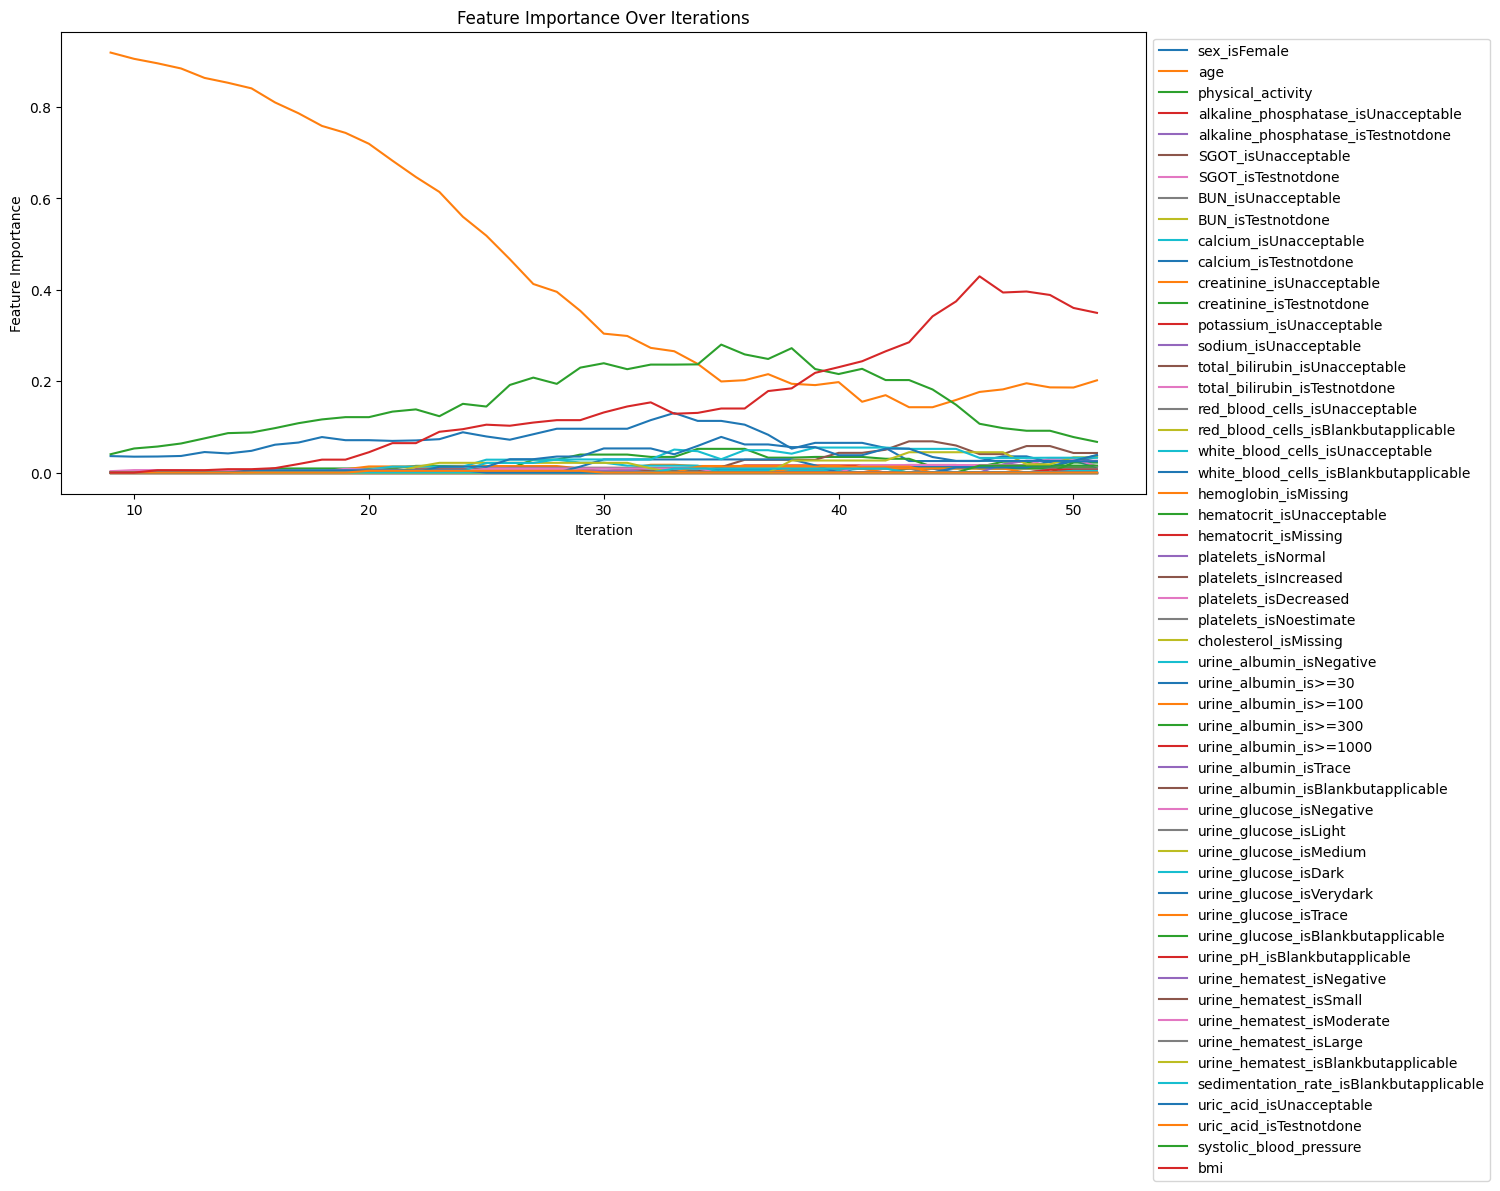

In [9]:
plot_feature_importances_per_iter(feature_importances_per_iter, feature_name_mappings=feature_name_mappings)

As seen above, age and systolic blood pressure has the largest impact on survival times. <br>
However, the effect of bmi starts to become significant after 35 iterations, which can be hard to interpret and explain.

In [10]:
print(f'Early stopping by feature importance at iteration:',
      f'{get_feature_importance_early_stopping_iter(feature_importances_per_iter, 1, threshold=0.25, n_iter_no_change=3)}')

Early stopping by feature importance at iteration: 36


#### Feature Impact Tracking

In [11]:
feature_impacts_per_iter = gbr.get_feature_impacts_per_iteration()
feature_impacts_per_iter['feature'] = feature_impacts_per_iter['feature'].apply(lambda x: feature_name_mappings[x])
display(feature_impacts_per_iter.groupby('feature').sum().sort_values(by='impact', ascending=False))

,iteration,impact,normalized_impact,samples
feature,,,,
systolic_blood_pressure,1037,1.042052e+06,13.239824,175410
age,1220,7.558136e+05,11.365731,185778
bmi,1098,4.952123e+05,6.964377,122938
urine_glucose_isVerydark,323,3.030239e+05,4.136130,38149
urine_glucose_isDark,285,2.218497e+05,3.029176,36512
urine_glucose_isMedium,181,2.064114e+05,2.347931,11771
sex_isFemale,585,1.590741e+05,2.518814,124574
urine_albumin_is>=30,157,1.243393e+05,1.605431,17021
platelets_isDecreased,118,1.010097e+05,0.987280,13006


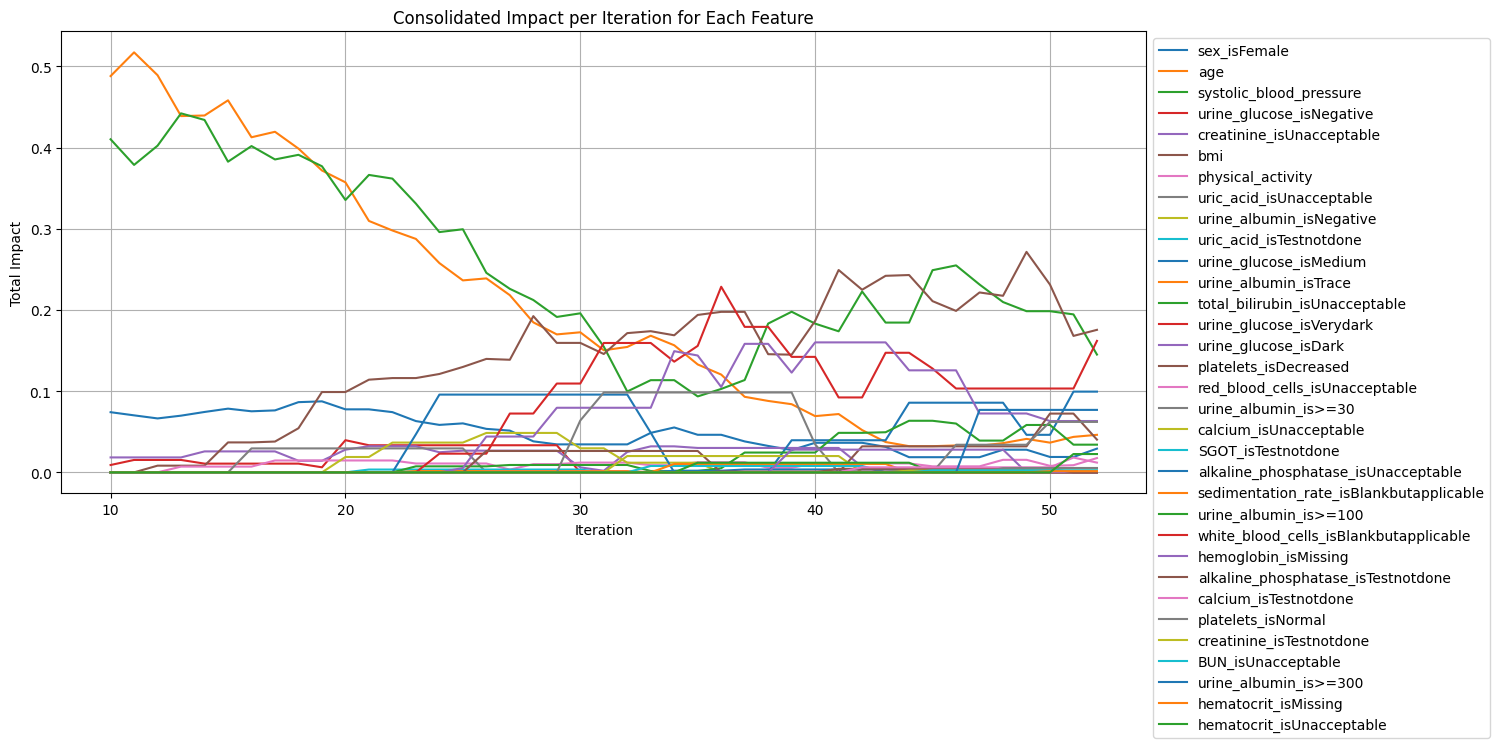

In [12]:
feature_impacts_per_iter = gbr.get_feature_impacts_per_iteration()
plot_feature_impacts_per_iter(feature_impacts_per_iter, feature_name_mappings=feature_name_mappings)

In [13]:
print(f' Early stopping by feature impact at iteration:',
      f'{get_feature_impact_early_stopping_iter(feature_impacts_per_iter, 1, threshold=0.1, n_iter_no_change=3)}')

 Early stopping by feature impact at iteration: 38


Depending on what the practitioner wants, they gain insights into how high impact/importance features like age and systolic blood pressure affect the model's behaviour.
However, it can be seen here that systolic blood pressure affects the predictions almost as much as age does, despite having a significantly lower feature importance.
Once again, feature importance does not equal to feature impact. A good feature may have high feature importance and low feature impact, and vice versa.

#### Comparing model performances using early stopping with feature importance vs normal early stopping

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE) for normal early stopping: {mse:.5f}")
print(f"Mean Absolute Error (MAE) for normal early stopping: {mae:.5f}")

Mean Squared Error (MSE) for normal early stopping: 133.58596
Mean Absolute Error (MAE) for normal early stopping: 8.49277


In [15]:
# Train CustomGBR with stopping decided by feature importance tracking
gbr = CustomGBR(n_estimators=36, learning_rate=0.1, max_depth=3, validation_fraction=0.2, n_iter_no_change=10, tol=0.001, random_state=42)
gbr.fit(X_train, y_train)


CustomGBR(n_estimators=36, n_iter_no_change=10, random_state=42, tol=0.001,
          validation_fraction=0.2)

In [16]:
y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE) for feature importance based early stopping: {mse:.5f}")
print(f"Mean Absolute Error (MAE) for feature importance based early stopping: {mae:.5f}")

Mean Squared Error (MSE) for feature importance based early stopping: 133.75803
Mean Absolute Error (MAE) for feature importance based early stopping: 8.58399


By stopping at iteration 36, we can potentially make the model more explainable, avoiding the difficult-to-explain effect of 
<br>bmi becoming a significantly important feature 
only after a certain number of iterations.

#### Visualizing the Prediction's feature impacts vs TreeExplainer values

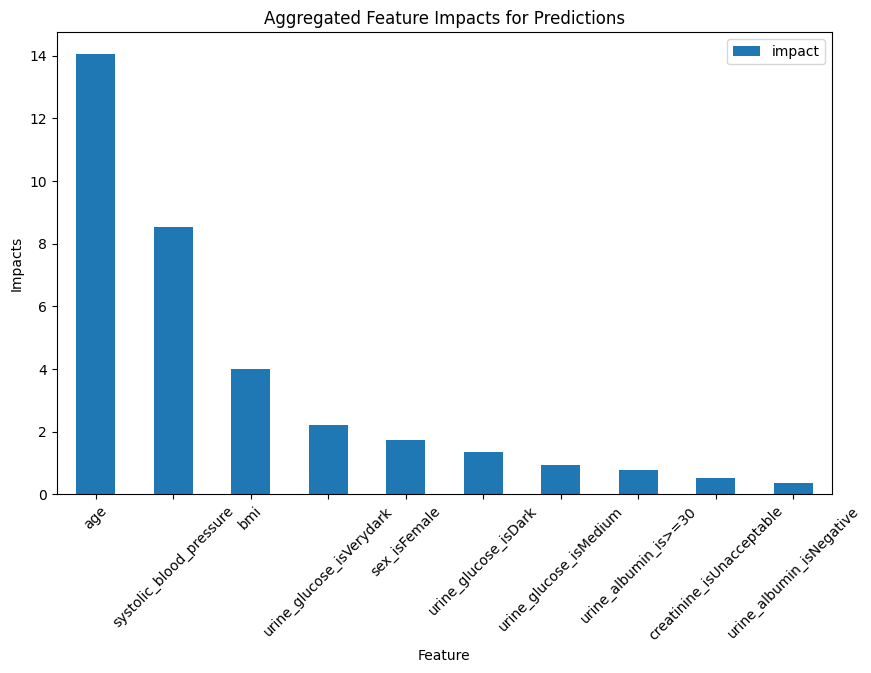

In [17]:
prediction_feature_impacts = gbr.get_predictions_feature_impacts(X_test)
plot_prediction_feature_impacts(prediction_feature_impacts, feature_name_mappings=feature_name_mappings, n_top=10)

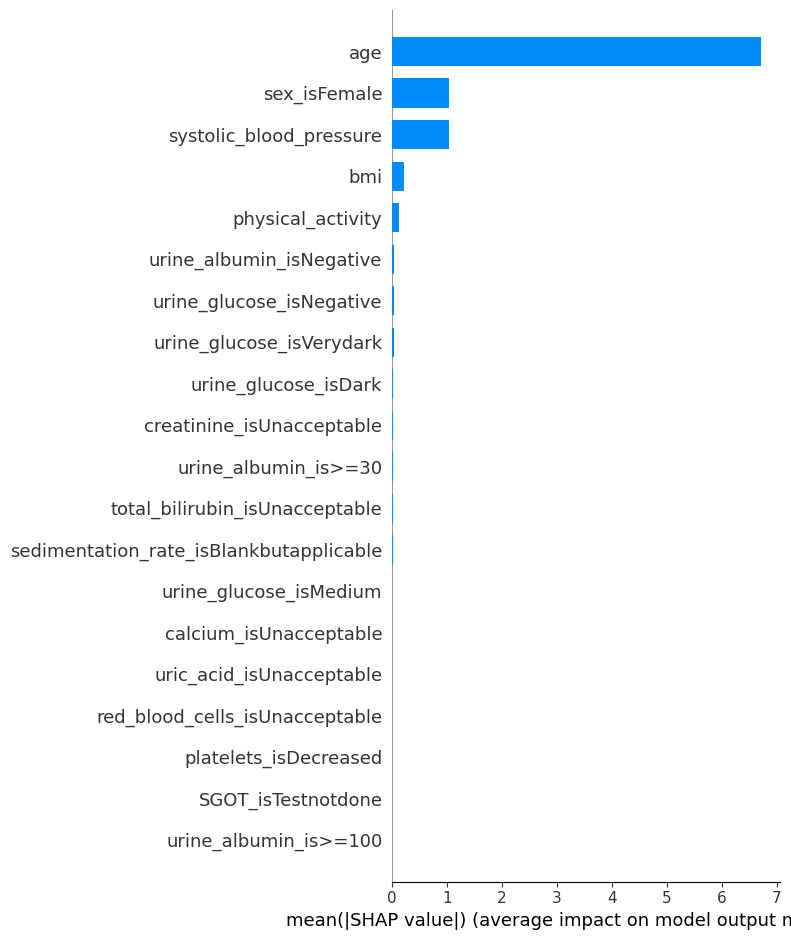

In [26]:
import shap
explainer = shap.TreeExplainer(gbr)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, feature_names=list(feature_name_mappings.values()), plot_type='bar')